<a href="https://colab.research.google.com/github/deeangular2/test/blob/master/NLP_For_Finance_DataCleaningSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP for Finance

## Introduction

With the application of NLP in financial markets comes the natural challenge of the need to collect and clean large datasets before applying any model. Many projects require substantial data scraping, data cleaning, data labeling, and data wrangling. Once we convert unstructured data to a more structured machine-readable form, we apply the latest ML/NLP models to answer essential questions about economics, and various financial markets.

This notebook covers the following:

* Download financial statements from SEC
* Word cloud of 8-K filing
* Text cleaning
* NLTK tokenization
* Stanza tokenization
* Sentiment analysis using VADER
* Sentiment analysis using FinBERT
* Create average sentiment for a given filing

## Install and Import Libraries

In [3]:
!pip install sec-edgar-downloader
!pip install transformers
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 933.2/933.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 9.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import re
from sec_edgar_downloader import Downloader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize, word_tokenize
import stanza
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Download financial statements from SEC
This will download 8-K filing which is the “current report” companies must file with the SEC to announce major events that shareholders should know about. This includes:

* <b>Management Changes</b>: This can include the appointment or departure of a CEO, CFO, or other key executives.
* <b>Acquisitions and Sales</b>: If a company buys another firm or sells one of its own divisions, it would file an 8-K.
* <b>Bankruptcy or Receivership</b>: If a company declares bankruptcy or enters receivership, this would be reported in an 8-K.
* <b>Material Impairments</b>: If a significant asset suddenly becomes impaired and is now less valuable to the company, this would be disclosed.
* <b>Changes to a Company's Bylaws or Charter</b>: Any significant amendments or modifications to the company's governing documents need to be reported.
* <b>Results of Operations and Financial Statements</b>: While companies provide regular updates to their financials every quarter (10-Q) and annually (10-K), if there's significant financial news that can't wait until the next 10-Q or 10-K, the company would file an 8-K.
* <b>Regulation FD Disclosure</b>: "FD" stands for "fair disclosure," and it requires that if a company tells anything important to one or a few analysts or investors, it has to tell everyone. So if a CEO unintentionally discloses material non-public information in a one-on-one setting, they might have to follow up with an 8-K to make that information public.

In [5]:
!pwd

/content


In [ ]:
help(Downloader)

Help on class Downloader in module sec_edgar_downloader._Downloader:

class Downloader(builtins.object)
 |  Downloader(company_name: str, email_address: str, download_folder: Union[str, pathlib.Path, NoneType] = None) -> None
 |  
 |  A :class:`Downloader` object.
 |  
 |  :param company_name: company name to comply with SEC Edgar's programmatic downloading
 |      fair access policy. All programmatic SEC interactions must declare a header comprised
 |      of a company name and email address.
 |      More info: https://www.sec.gov/os/webmaster-faq#code-support.
 |  :param email_address: email address to comply with SEC Edgar's programmatic downloading
 |      fair access policy. All programmatic SEC interactions must declare a header comprised
 |      of a company name and email address.
 |      More info: https://www.sec.gov/os/webmaster-faq#code-support.
 |  :param download_folder: relative or absolute path to download location.
 |      Defaults to the current working directory.
 | 

In [8]:
# Download filings to the current working directory
dl = Downloader(company_name="Georgia Tech",
                email_address="mgalarnyk3@gatech.edu",
                download_folder = "/content/" )

# Get the 8-K filing for MSFT from April 2018
dl.get("8-K", "COIN", after="2019-04-01", before="2024-04-30");

In [7]:
!ls


sample_data


In [16]:
!ls /Users/michaelgalarnyk/Desktop/vets_in_tech/MachineLearningCourse/Week6_NLP/notebooks/sec-edgar-filings/MSFT/8-K/0001193125-18-134732/full-submission.txt


ls: cannot access '/Users/michaelgalarnyk/Desktop/vets_in_tech/MachineLearningCourse/Week6_NLP/notebooks/sec-edgar-filings/MSFT/8-K/0001193125-18-134732/full-submission.txt': No such file or directory


In [17]:
# https://www.sec.gov/Archives/edgar/data/51143/000110465922099631/0001104659-22-099631-index.htm

# read data
with open('/content/sec-edgar-filings/COIN/8-K/0001104659-22-061625/full-submission.txt', encoding='utf-8') as f:
    text = f.read()

#print(text)

In [18]:
text

'<SEC-DOCUMENT>0001104659-22-061625.txt : 20220517\n<SEC-HEADER>0001104659-22-061625.hdr.sgml : 20220517\n<ACCEPTANCE-DATETIME>20220517060133\nACCESSION NUMBER:\t\t0001104659-22-061625\nCONFORMED SUBMISSION TYPE:\t8-K\nPUBLIC DOCUMENT COUNT:\t\t13\nCONFORMED PERIOD OF REPORT:\t20220516\nITEM INFORMATION:\t\tRegulation FD Disclosure\nITEM INFORMATION:\t\tFinancial Statements and Exhibits\nFILED AS OF DATE:\t\t20220517\nDATE AS OF CHANGE:\t\t20220517\n\nFILER:\n\n\tCOMPANY DATA:\t\n\t\tCOMPANY CONFORMED NAME:\t\t\tCoinbase Global, Inc.\n\t\tCENTRAL INDEX KEY:\t\t\t0001679788\n\t\tSTANDARD INDUSTRIAL CLASSIFICATION:\tFINANCE SERVICES [6199]\n\t\tIRS NUMBER:\t\t\t\t464707224\n\t\tSTATE OF INCORPORATION:\t\t\tDE\n\t\tFISCAL YEAR END:\t\t\t1231\n\n\tFILING VALUES:\n\t\tFORM TYPE:\t\t8-K\n\t\tSEC ACT:\t\t1934 Act\n\t\tSEC FILE NUMBER:\t001-40289\n\t\tFILM NUMBER:\t\t22932126\n\n\tBUSINESS ADDRESS:\t\n\t\tSTREET 1:\t\tC/O THE CORPORATION TRUST COMPANY\n\t\tSTREET 2:\t\t1209 ORANGE STREET\n\t\t

## Word cloud of 8-K filing

In a word cloud, (typically) the more frequently a word appears in a text, the bigger and bolder it appears in the word cloud. In this case, it can be used to identify common but irrelevant words (stop words) or terms that might not need to be included in the analysis.

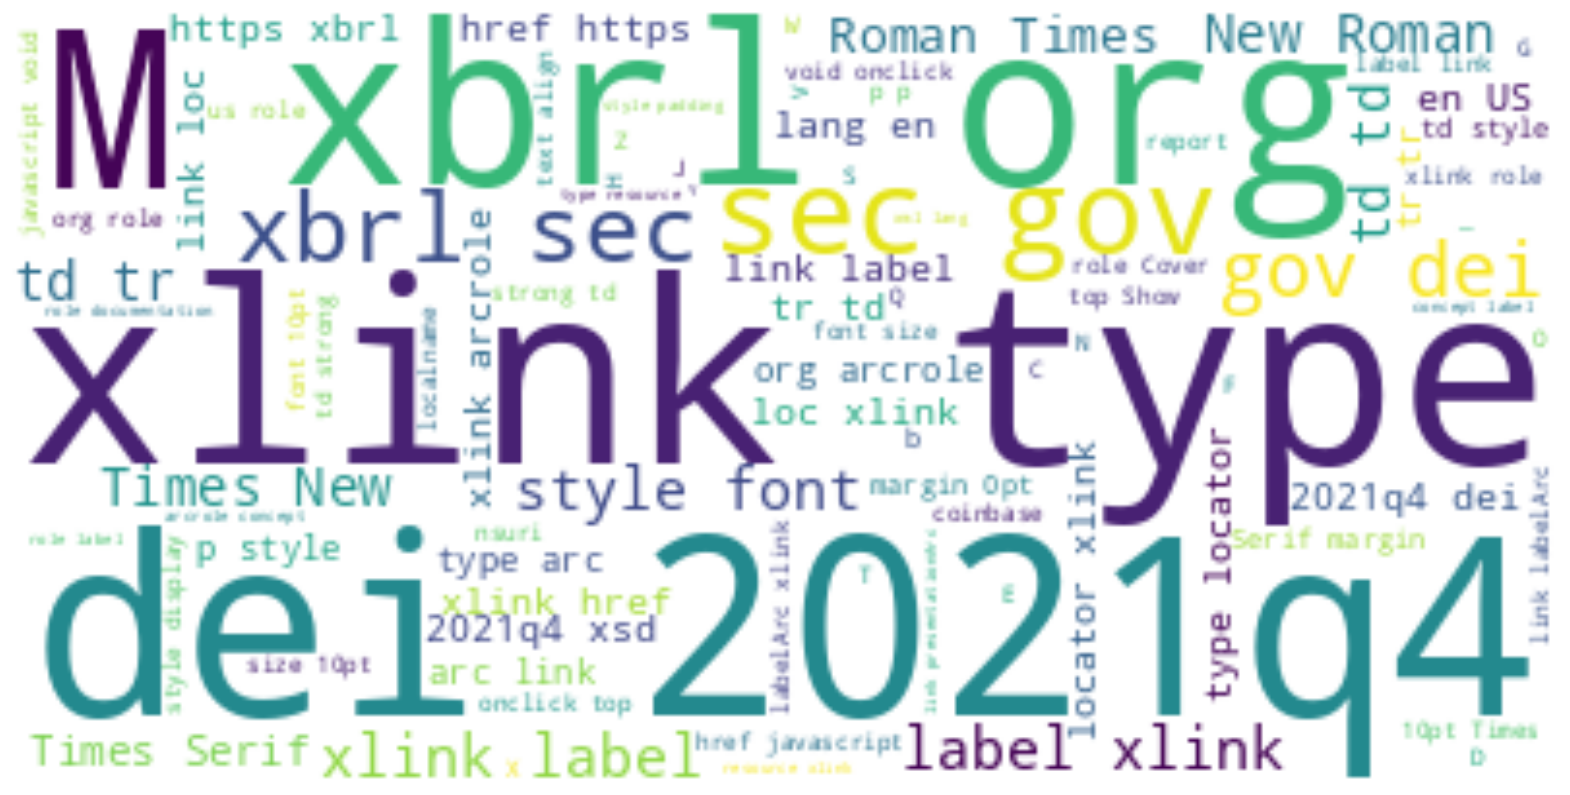

In [19]:
# load stop words
stopwords = set(STOPWORDS)
stopwords.update(["page", "table", 'document'])

# word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# display the generated image
plt.figure(figsize=(20, 50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## Text cleaning

This isn't a major concern for bag of words (if you have dictionary of words), but there is definitely noise in this data. It can be a problem for words like "margin" which have meaning in HTML and finance.

The goal is to do cleaning so that the signal to noise ratio is large enough for the analysis to make sense.

In [20]:
response = text

response = re.sub(r'(\r\n|\r|\n)', ' ', response) # \r new line in macOS, \n in Unix and \r\n in Windows

# remove certain text with regex query
response = re.sub(r'<DOCUMENT>\s*<TYPE>(?:GRAPHIC|ZIP|EXCEL|PDF|XML|JSON).*?</DOCUMENT>', ' ', response)
response = re.sub(r'<SEC-HEADER>.*?</SEC-HEADER>', ' ', response)
response = re.sub(r'<IMS-HEADER>.*?</IMS-HEADER>', ' ', response)

# replace characters to correct them
response = re.sub(r'&nbsp;', ' ', response)
response = re.sub(r'&#160;', ' ', response)
response = re.sub(r'&amp;', '&', response)
response = re.sub(r'&#38;', '&', response)

# replace other encoded characters to whitespace
response = re.sub(r'&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', response)

soup = bs(response, 'html.parser')

for tag in soup.find_all('xbrl'):
    # don't remove if there is item detail
    fp_result = tag(text=re.compile(r'(?i)item\s*\d', re.IGNORECASE))
    event = len(fp_result)

    ## if no item details remove that part
    # decompose() method removes a tag as well as its inner content.
    if (event==0):
        tag.decompose()

# remove tables
for tag in soup.find_all('table'):
    temp_text = tag.get_text()
    numbers = sum(c.isdigit() for c in temp_text)
    letters = sum(c.isalpha() for c in temp_text)
    ratio_number_letter = 1.0
    if (numbers + letters) > 0:
        ratio_number_letter = numbers/(numbers + letters)

    event = 0
    if( (event==0) and ( ratio_number_letter > 0.1)):
        tag.decompose()


## remove other text between tags used for styling
text = soup.get_text()
text = re.sub(r'<(?:ix|link|xbrli|xbrldi).*?>.*?<\/.*?>', ' ', text)

## remove extra whitespace from sentences
text = "".join(line.strip() for line in text.split("\n"))

## some additional cleaning
text = re.sub(r'--;', ' ', text)
text = re.sub(r'__', ' ', text)

cleanr = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
text = re.sub(cleanr, ' ', text)

temp_match = re.search(r'^.*?item(\s)*\d', text, flags=re.IGNORECASE)
if temp_match != None:
    text = re.sub(r'^.*?item(\s)*\d', '', text, count=1, flags=re.IGNORECASE)

## replace more than one whitespace with single whitespace
text = re.sub(r'\s+', ' ', text)

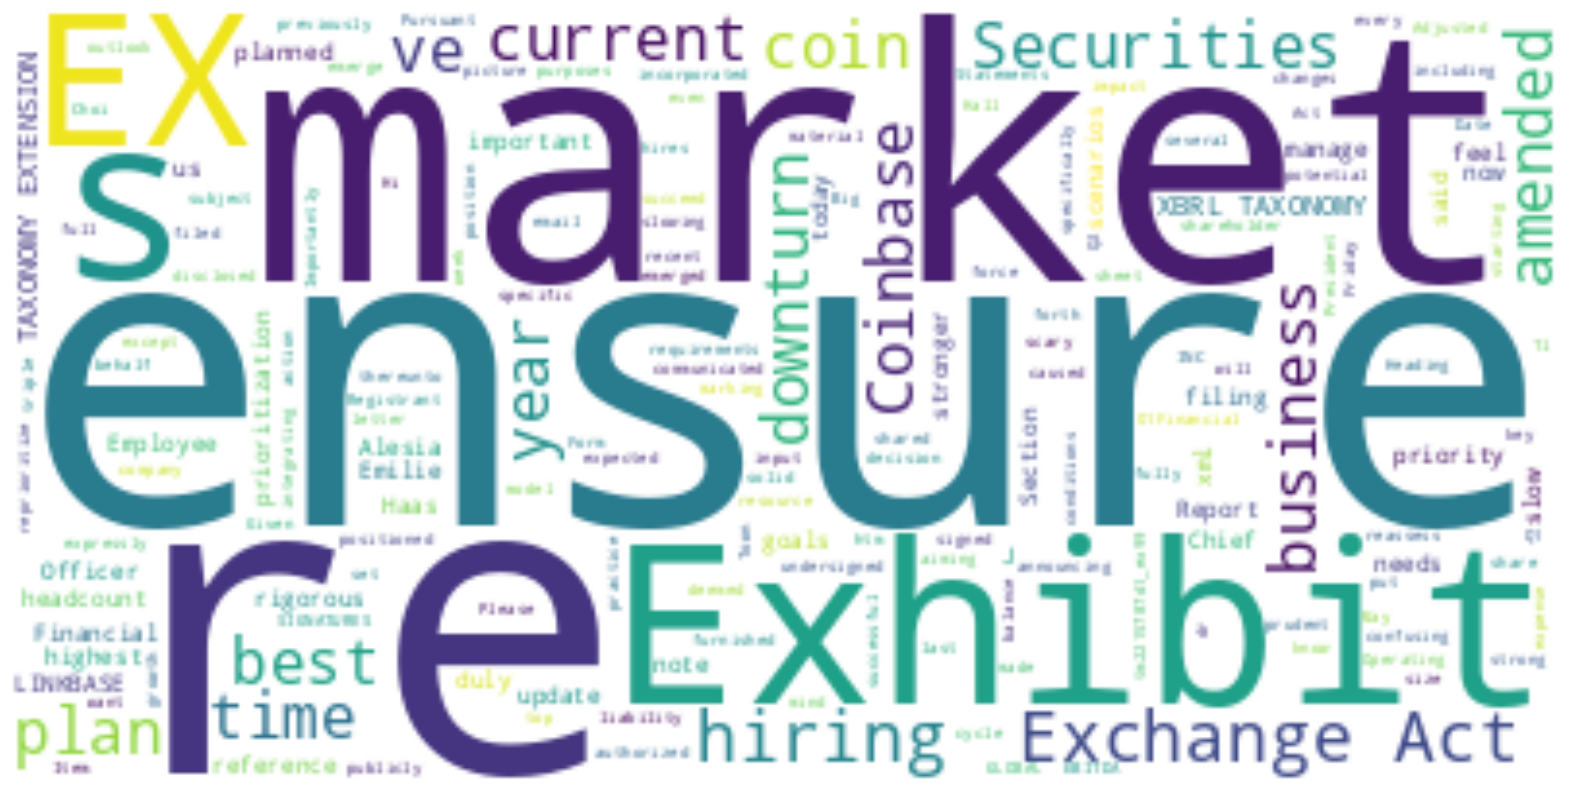

In [21]:
# new word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# display the generated image
plt.figure(figsize=(20, 50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## NLTK tokenization

Tokenization involves breaking down a large paragraph or text into smaller chunks, usually words or sentence. This is done to simplify text data, break down into basic units of meaning, and format inputs for algorithms. [NLTK can also help you remove stop words as well.](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)

In [ ]:
# Word tokenization
tokenized_words = word_tokenize(text)
print("Number of words: ", len(tokenized_words))
print("Sample of words: ", tokenized_words[:10])

Number of words:  1915
Sample of words:  ['.02', '.', 'Results', 'of', 'Operations', 'and', 'Financial', 'Condition', 'On', 'April']


In [22]:
# Sentence tokenization
tokenized_sents = sent_tokenize(text)
print("Number of sentences: ", len(tokenized_sents))
print("Sample of sentences: ", tokenized_sents[4:7])

Number of sentences:  18
Sample of sentences:  ['Date: May 17, 2022 By: /s/ Alesia J. Haas Alesia J. Haas Chief Financial Officer EX-99.1 2 tm2215787d1_ex99-1.htm EXHIBIT 99.1 Exhibit 99.1 Employee note: An update on hiring plans By Emilie Choi, President and Chief Operating Officer I shared an update with our employees today that I want to also share publicly.', 'Please note that these changes are not expected to have any material impact to our previously communicated expense outlook for Q2, or full-year 2022, as disclosed in our Q1 shareholder letter.', 'Tl;dr: To ensure we re best positioned to succeed during and after the current market downturn, we re announcing we re slowing hiring so we can reprioritize our hiring needs against our highest-priority business goals.']


### Stanza tokenization

[Stanza](https://aclanthology.org/2020.acl-demos.14.pdf) has some advantages over NLTK including:

* <b>State-of-the-art performance</b>: It's neural pipeline adapts well to text of different genres, achieving state-of-the-art or competitive performance at each step of the pipeline (including tokenization, part-of-speech tagging, named entity recognition, and dependency parsing)

* <b>Multilingual Support</b>: While both NLTK and Stanza support multiple languages, Stanza offers pretrained models for more than 66 languages. This broad coverage can be particularly appealing for projects that deal with less commonly addressed languages.

* <b>Integration with the Stanford CoreNLP Suite</b>: For users who want to use the broader functionalities provided by the Stanford CoreNLP suite (a Java-based NLP toolset), Stanza provides a native Python interface to CoreNLP, making it easier to integrate.

* <b>GPU Support</b>: Stanza's neural models can be accelerated using GPUs, making it faster to process large datasets or perform intensive tasks.

* <b>Performance on Modern Language Constructs</b>: It tends to perform better on informal, web-based text or text with modern language constructs and slang, given the right training data.

In [23]:
## Take following example text
example_text = 'This is a test sentence for stanza.\n\nThis is another sentence. This is tokenization done my way!Sentence split, too.'

## tokenise using NLTK
print(sent_tokenize(example_text))

['This is a test sentence for stanza.', 'This is another sentence.', 'This is tokenization done my way!Sentence split, too.']


In [24]:
## Tokenise using Stanza
## Reference: https://stanfordnlp.github.io/stanza/tokenize.html
nlp = stanza.Pipeline(lang='en', processors='tokenize')
doc = nlp(example_text)
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print("Sentence: ", sentence.text)
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!


====== Sentence 1 tokens =======
Sentence:  This is a test sentence for stanza.
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: test
id: (5,)	text: sentence
id: (6,)	text: for
id: (7,)	text: stanza
id: (8,)	text: .
====== Sentence 2 tokens =======
Sentence:  This is another sentence.
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: another
id: (4,)	text: sentence
id: (5,)	text: .
====== Sentence 3 tokens =======
Sentence:  This is tokenization done my way!
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: tokenization
id: (4,)	text: done
id: (5,)	text: my
id: (6,)	text: way
id: (7,)	text: !
====== Sentence 4 tokens =======
Sentence:  Sentence split, too.
id: (1,)	text: Sentence
id: (2,)	text: split
id: (3,)	text: ,
id: (4,)	text: too
id: (5,)	text: .


## Sentiment analysis using VADER

[VADER](https://ojs.aaai.org/index.php/icwsm/article/view/14550) was originally trained on social media so it is not ideal at sentiment analysis for finance.

In [25]:
sid = SentimentIntensityAnalyzer()

sentiment_score = sid.polarity_scores('The revenue increased over last quarter.')

print("Overall Sentiment score: ", sentiment_score)
print("sentence was rated as ", sentiment_score['neg']*100, "% Negative")
print("sentence was rated as ", sentiment_score['neu']*100, "% Neutral")
print("sentence was rated as ", sentiment_score['pos']*100, "% Positive")

Overall Sentiment score:  {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.2732}
sentence was rated as  0.0 % Negative
sentence was rated as  70.39999999999999 % Neutral
sentence was rated as  29.599999999999998 % Positive


The compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).

In general,

- positive sentiment: (compound score $\ge$ 0.05)  
- neutral sentiment: (0.05 $>$ compound score $>$ -0.05)
- negative sentiment: (compound score $\le$ -0.05)

## Sentiment analysis using FinBERT

[FinBERT](https://arxiv.org/pdf/1908.10063.pdf) was created because financial sentiment analysis is a challenging task due to the specialized language and lack of labeled data in that domain. General purpose models are not effective enough because of specialized
language used in financial context. The model is located on [Hugging Face](https://huggingface.co/ipuneetrathore/bert-base-cased-finetuned-finBERT).

For the model,

* LABEL_2 is positive
* LABEL_1 is neutral
* LABEL_0 is negative

In [26]:
tokenizer = AutoTokenizer.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
model = AutoModelForSequenceClassification.from_pretrained("ipuneetrathore/bert-base-cased-finetuned-finBERT")
# classifier = pipeline('sentiment-analysis', model= model, tokenizer=tokenizer, device=0, framework="pt")
classifier = pipeline('sentiment-analysis', model= model, tokenizer=tokenizer, framework="pt")

results = classifier(['The revenue increased above and beyond over last quarter.', 'We did poorly on sells', 'The inflation increased over last year.', 'it is a normal trading day'], batch_size=2, truncation="only_first")
print(results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

[{'label': 'LABEL_2', 'score': 0.9999865293502808}, {'label': 'LABEL_0', 'score': 0.9999457597732544}, {'label': 'LABEL_2', 'score': 0.9999114274978638}, {'label': 'LABEL_1', 'score': 0.9999908208847046}]


## Create average sentiment for a given filing

In [28]:
sentiment_results_filing = classifier(tokenized_sents, batch_size=2, truncation="only_first")

count_positive_sents = 0
count_negative_sents = 0
count_total_sents = len(tokenized_sents)

for sent in sentiment_results_filing:
    if sent['label'] == 'LABEL_2':
        count_positive_sents = count_positive_sents + 1
    if sent['label'] == 'LABEL_0':
        count_negative_sents = count_negative_sents + 1

measure_value = (count_positive_sents - count_negative_sents)/count_total_sents

print("Sentiment measure for COINBASE: ", measure_value)

Sentiment measure for COINBASE:  0.2222222222222222


## Task

1) Now modify the notebook for a different company and even time period.

2) Tell me about how the stock did before and after that filing.

3) Does sentiment matter for a 8-K?